In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi, gaussian, threshold_otsu, threshold_yen, threshold_multiotsu
from skimage.color import rgb2gray
import skimage.morphology as mp
from skimage import exposure
import math

In [2]:
image_name = 'healthy/01_h.jpg'
image_fov = 'healthy_fovmask/01_h_mask.tif'

In [3]:
def detect_vessels(img, image_fov):
    # Normalizacja histogramu kolorów
    colorimage_b = img[:,:,0]
    colorimage_g = cv2.equalizeHist(img[:,:,1])
    colorimage_r = img[:,:,2]
    img = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Usuwanie szumów przy pomocy gaussiana
    img = gaussian(img, sigma=(10), channel_axis=-1)

    # Zmiana na skalę szarości
    img = rgb2gray(img)
    
    # Filtra frangi
    img = frangi(img)

    # Morfologiczna dylatacja (rozszerzenie) i erozja (skurczenie)
    img = mp.dilation(img, mp.disk(4))
    img = mp.erosion(img, mp.disk(4))
    
    # Progowanie Otsu
    thresh = threshold_otsu(img)
    img = img > thresh * 0.1
    
    # Otwieranie fov, iterujemy po pliku
    for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    if image_fov[x][y] == 0:
                        img[x][y] = 0
                        
    return img

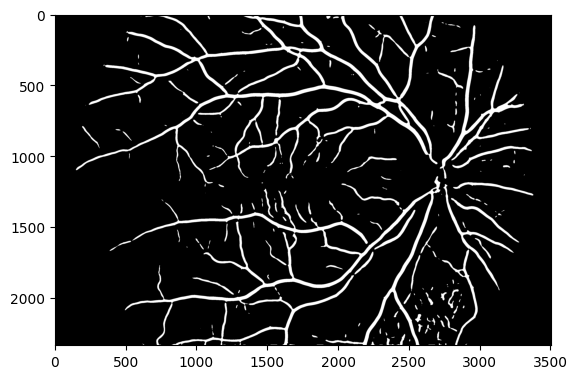

In [4]:
image =  cv2.imread(image_name)
fov =  cv2.imread(image_fov, cv2.IMREAD_GRAYSCALE)
img = detect_vessels(image, fov)
plt.imshow(img,cmap='gray')

In [5]:
image_manual = 'healthy_manual/01_h.tif'

In [59]:
def conf_matrix_for_image(image, manual):
    h, w = manual.shape
    tp, fp, fn, tn = 0, 0, 0, 0

    result = np.zeros(shape=(h,w,3))
    
    for i in range(h):
        for j in range(w):
            if image[i][j] == 1 and manual[i][j] == 255:
                tp += 1
                result[i][j][1] = 1
            if image[i][j] == 1 and manual[i][j] == 0:
                fp += 1
                result[i][j][0] = 1
            if image[i][j] == 0 and manual[i][j] == 255:
                fn += 1
                result[i][j][2] = 1
            if image[i][j] == 0 and manual[i][j] == 0:
                tn += 1

    accuracy = (tp + tn) / (tn + fp + fn + tp) * 100
    sensivity = tp / (tp + fn + 1) * 100
    specifity = tn / (fp + tn + 1) * 100
    geometric_mean = math.sqrt((sensivity * specifity))
    return (accuracy, sensivity, specifity, geometric_mean, result)

In [7]:
manual = cv2.imread(image_manual, cv2.IMREAD_GRAYSCALE)
acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(img, manual)
print(f"Accuracy: {acc:.2f}  Sensitivity: {sens:.2f}  Specificity: {spec:.2f}  Geometric mean: {geo_mean:.2f}")

Accuracy: 94.90  Sensitivity: 69.68  Specificity: 97.76  Geometric mean: 82.53


In [8]:
image = cv2.imread('healthy/0' + str(1) + '_h.jpg')
fov_image = cv2.imread('healthy_fovmask/0' + str(1) + '_h_mask.tif',cv2.IMREAD_GRAYSCALE)
manual_image = cv2.imread('healthy_manual/0' + str(1) + '_h.tif', cv2.IMREAD_GRAYSCALE)

predicted_image = detect_vessels(image,fov_image)
acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(predicted_image, manual_image)
print(f"Accuracy: {acc:.2f}  Sensitivity: {sens:.2f}  Specificity: {spec:.2f}  Geometric mean: {geo_mean:.2f}")

Accuracy: 94.90  Sensitivity: 69.68  Specificity: 97.76  Geometric mean: 82.53


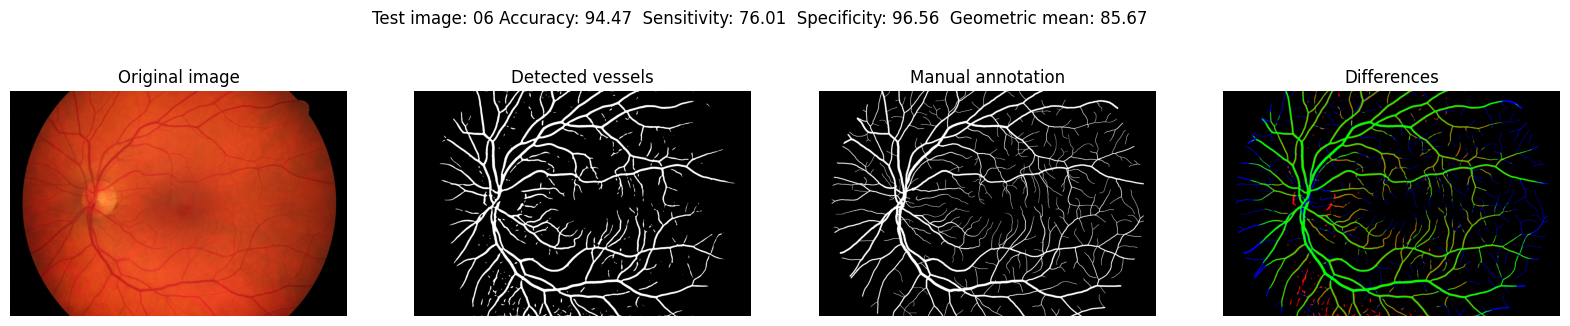

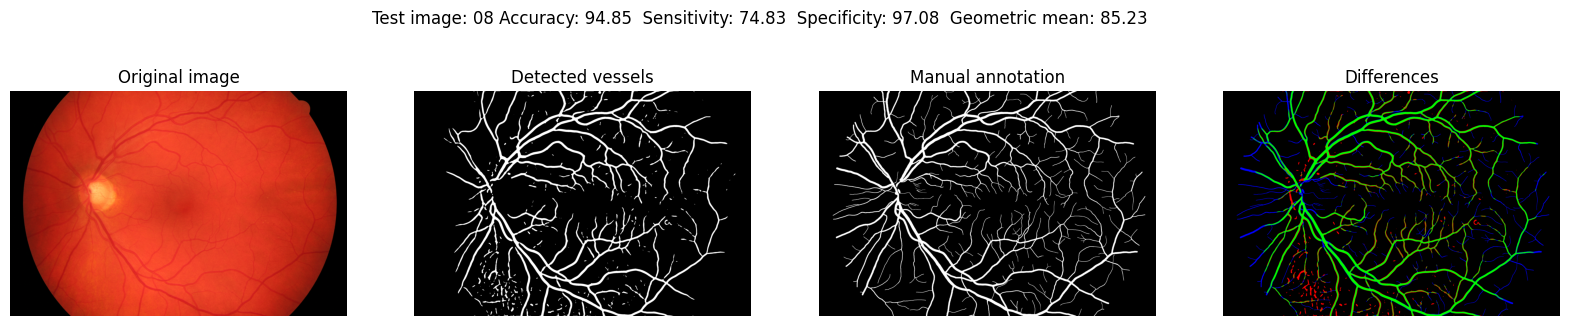

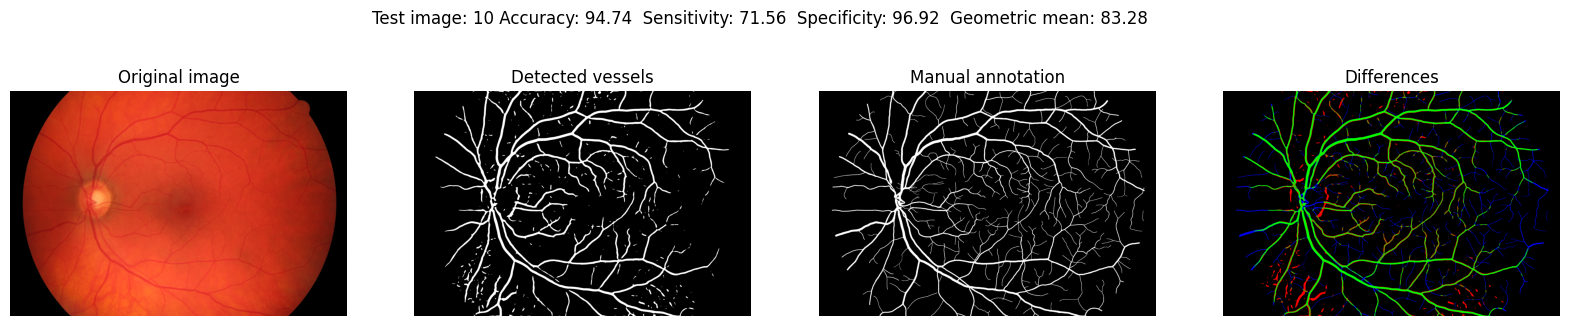

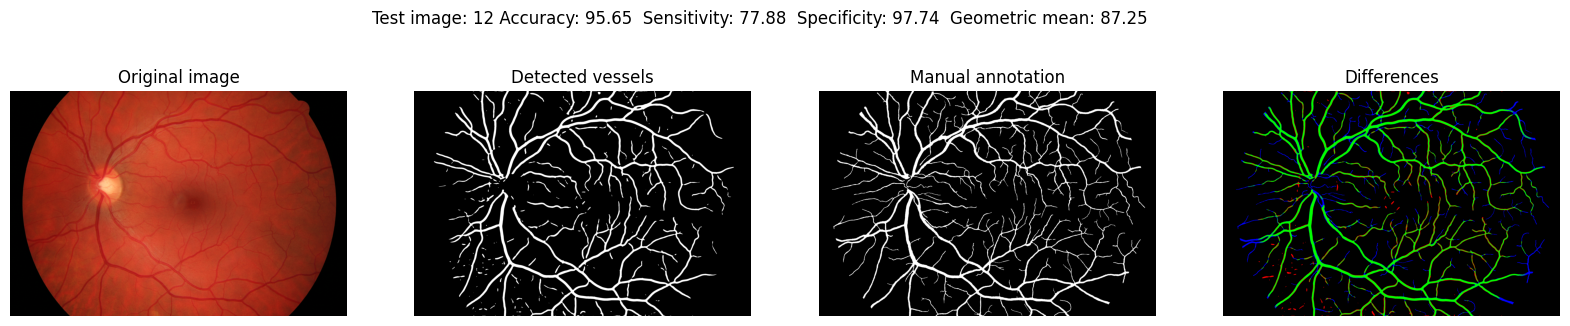

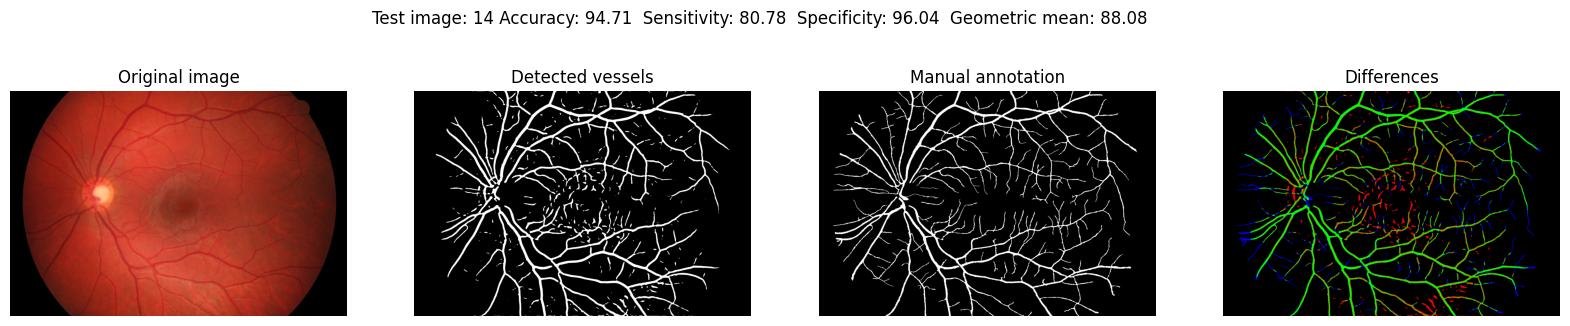

In [51]:
images_to_test = ['06', '08', '10', '12', '14']
for x in images_to_test:
    fig, axes = plt.subplots(figsize=(20,4),nrows=1, ncols=4)
    
    image = cv2.imread('healthy/' + str(x) + '_h.jpg')
    fov_image = cv2.imread('healthy_fovmask/' + str(x) + '_h_mask.tif',cv2.IMREAD_GRAYSCALE)
    manual_image = cv2.imread('healthy_manual/' + str(x) + '_h.tif', cv2.IMREAD_GRAYSCALE)
    
    predicted_image = detect_vessels(image,fov_image)
    acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(predicted_image, manual_image)

    fig.suptitle(f"Test image: {x} Accuracy: {acc:.2f}  Sensitivity: {sens:.2f}  Specificity: {spec:.2f}  Geometric mean: {geo_mean:.2f}")
    
    axes[0].set_title("Original image")
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    
    axes[1].set_title("Detected vessels")
    axes[1].imshow(predicted_image, cmap='gray')
    axes[1].axis('off')
    
    axes[2].set_title("Manual annotation")
    axes[2].imshow(manual_image, cmap='gray')
    axes[2].axis('off')
    
    axes[3].set_title("Differences")
    axes[3].imshow(results_img, cmap='gray')
    axes[3].axis('off')

    plt.show()

In [10]:
image = cv2.imread('healthy/0' + str(1) + '_h.jpg')
manual = cv2.imread('healthy_manual/0' + str(1) + '_h.tif')

In [19]:
CLIP_SIZE = 5

def create_tiles(image, gray_image, manual): 
    clips = []
    gray_clips = []
    manual_mid_pixel = []
    
    h, w, _ = image.shape
    for x in range(h - CLIP_SIZE + 1):
        for y in range(w - CLIP_SIZE + 1):
            clip = image[x:x+CLIP_SIZE,y:y+CLIP_SIZE]
            clips.append(clip)
            
            clip_gray = gray_image[x:x+CLIP_SIZE,y:y+CLIP_SIZE]
            gray_clips.append(clip_gray)

            clip_manual = manual[x:x+CLIP_SIZE,y:y+CLIP_SIZE]
            mid = clip_manual[CLIP_SIZE//2, CLIP_SIZE//2]
            manual_mid_pixel.append(mid)
    return clips, gray_clips, manual_mid_pixel


def get_features(image_tiles, gray_image_tiles):
    features = []
    for x in range(len(image_tiles)):
        clip, clip_gray = image_tiles[x], gray_image_tiles[x]

        channels = clip.reshape(-1, 3)
        std = np.std(channels, axis=0)
        mean = np.mean(channels, axis=0)

        moments = cv2.moments(clip_gray)
        hu_moments = cv2.HuMoments(moments).flatten()

        features.append(np.hstack([mean, std, hu_moments]))

    return features

In [20]:
image = cv2.resize(image, (600, 600))
manual = cv2.resize(manual, (600, 600))
tiles, gray_tiles, manual_tiles = create_tiles(image,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(manual, cv2.COLOR_BGR2GRAY))

features = get_features(tiles, gray_tiles)

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from joblib import dump, load
from skimage import filters

In [22]:
def preprocess_image(img):
    # Normalizacja histogramu kolorów
    colorimage_b = img[:,:,0]
    colorimage_g = cv2.equalizeHist(img[:,:,1])
    colorimage_r = img[:,:,2]
    img = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sharpened_image = filters.unsharp_mask(img)
    return sharpened_image

In [75]:
def create_training_model():
    features = []
    manual = []

    for x in range(1,6):
        print(f'On image {x}')
        image = cv2.imread('healthy/0' + str(x) + '_h.jpg')
        image = cv2.resize(image, (600, 600))
        
        image_gray = preprocess_image(image)
        
        healthy_fov = cv2.imread('healthy_fovmask/0' + str(x) + '_h_mask.tif')
        healthy_fov = cv2.resize(healthy_fov, (600, 600))
        healthy_fov = cv2.cvtColor(healthy_fov, cv2.COLOR_BGR2GRAY)
        healthy_fov = healthy_fov > 100
        image_gray[healthy_fov == 0] = 0

        healthy_manual = cv2.imread('healthy_manual/0' + str(x) + '_h.tif')
        healthy_manual = cv2.resize(healthy_manual, (600, 600))
        healthy_manual = cv2.cvtColor(healthy_manual, cv2.COLOR_BGR2GRAY)
        healthy_manual = healthy_manual > 10
        healthy_manual[healthy_fov == 0] = 0
        
        img_tiles, img_gray_tiles, manual_tiles = create_tiles(image, image_gray, healthy_manual)
        feature = get_features(img_tiles, img_gray_tiles)

        features.extend(feature)
        manual.extend(manual_tiles)

    features = np.array(features)
    manual = np.array(manual)
    
    print("Sampling")
    rus = RandomUnderSampler()
    features, labels = rus.fit_resample(features, manual)

    print("Train test and split")
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

    classifier = RandomForestClassifier(n_estimators=200, n_jobs=-1)

    param_dist = {
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    }

    print("Classifier")
    classifier = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=20, cv=2, scoring='accuracy', n_jobs=-1)

    print("Fitting")
    classifier.fit(X_train, y_train)

    accuracy = classifier.score(X_test, y_test)

    print("Best parameters found:", classifier.best_params_)
    print("Accuracy on test set:", accuracy)

    dump(classifier, "new_model.pkl")


create_training_model()

On image 1
On image 2
On image 3
On image 4
On image 5
Sampling
Train test and split
Classifier
Fitting
Best parameters found: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Accuracy on test set: 0.8939019316959835


In [77]:
def load_classifier():
  return load("new_model.pkl")

loaded_classifier = load_classifier()

def get_new_image(image, predicted):
    height, width = image.shape
    new_image = np.zeros((height, width))
         
    for y in range(0, height - 5 + 1):
        for x in range(0, width - 5 + 1):
            new_image[y:y + 5, x:x + 5] = predicted[0]
            predicted = predicted[1:]
    return new_image

In [78]:
def process_images(image_number):
    image = cv2.imread('healthy/' + str(image_number) + '_h.jpg')
    image = cv2.resize(image, (600, 600))
    
    gray_image = preprocess_image(image)
    
    healthy_fov = cv2.imread("healthy_fovmask/" + str(image_number) + "_h_mask.tif")
    healthy_fov = cv2.resize(healthy_fov, (600, 600))
    healthy_fov = cv2.cvtColor(healthy_fov, cv2.COLOR_BGR2GRAY)
    
    healthy_manual = cv2.imread('healthy_manual/' + str(image_number) + '_h.tif')
    manual = cv2.resize(healthy_manual, (600, 600))
    manual = cv2.cvtColor(manual, cv2.COLOR_BGR2GRAY)

    classifier = loaded_classifier
    it, gt, mt = create_tiles(image, gray_image, manual)
    predictions = classifier.predict(get_features(it, gt))
    predicted_image = get_new_image(gray_image, predictions)
    
    manual = cv2.normalize(manual, None, 0, 255, cv2.NORM_MINMAX)
    manual = manual.astype(np.uint8)

    return image, predicted_image, manual

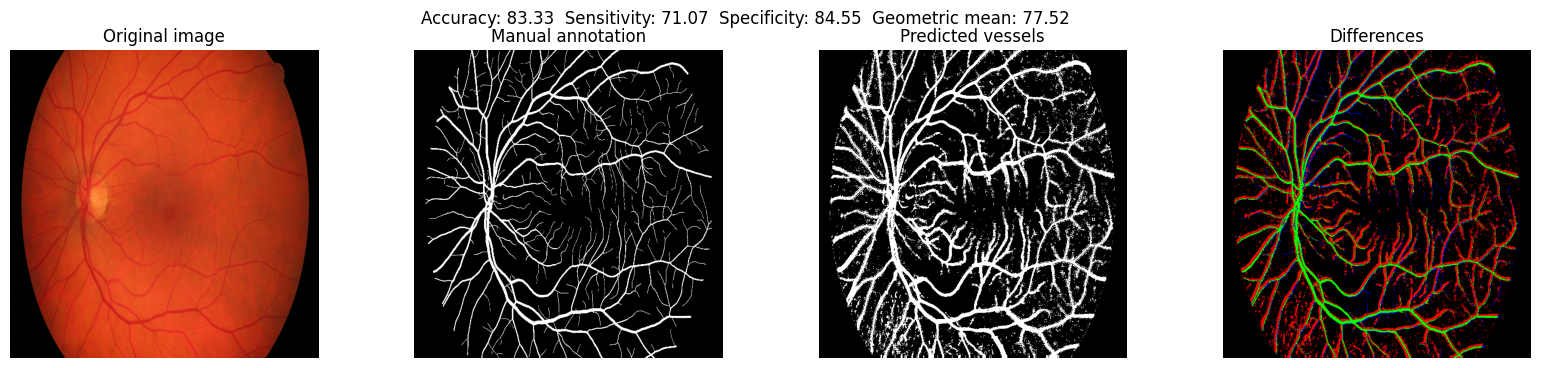

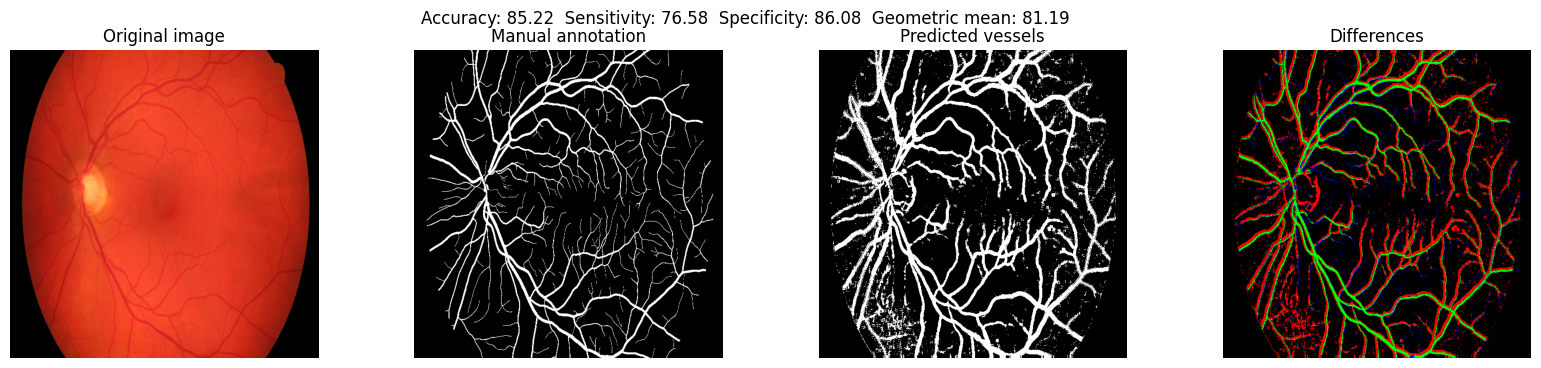

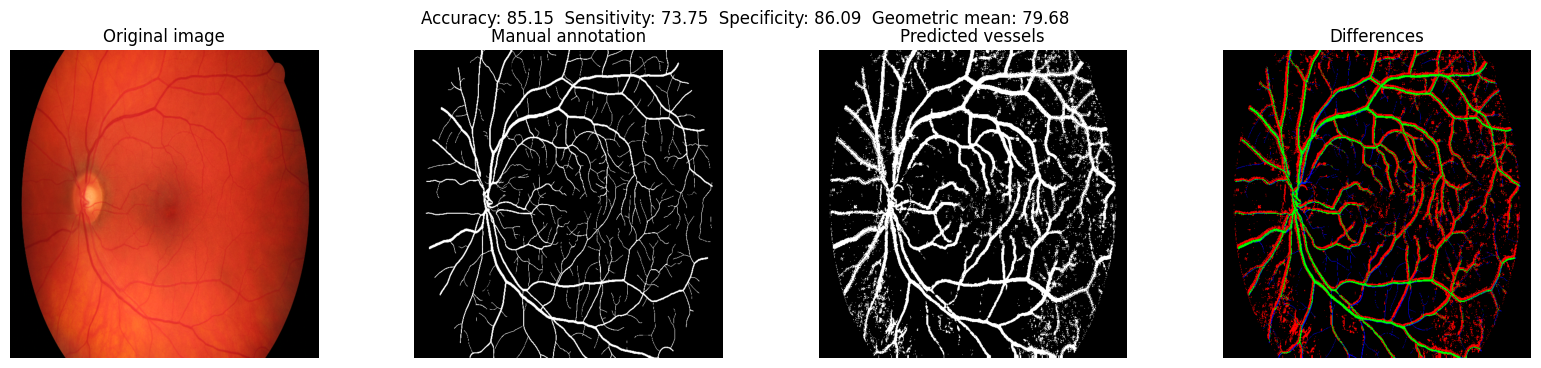

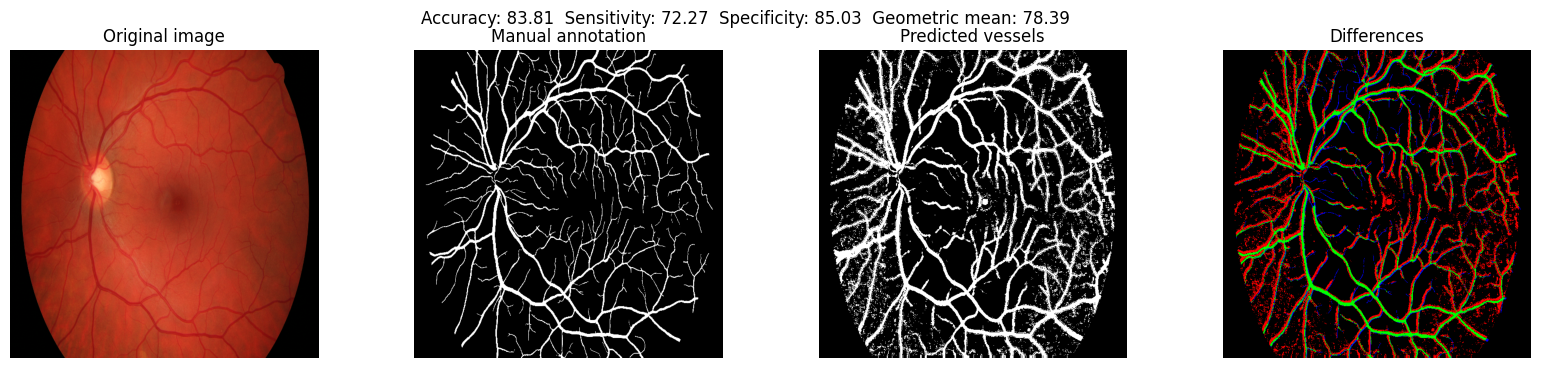

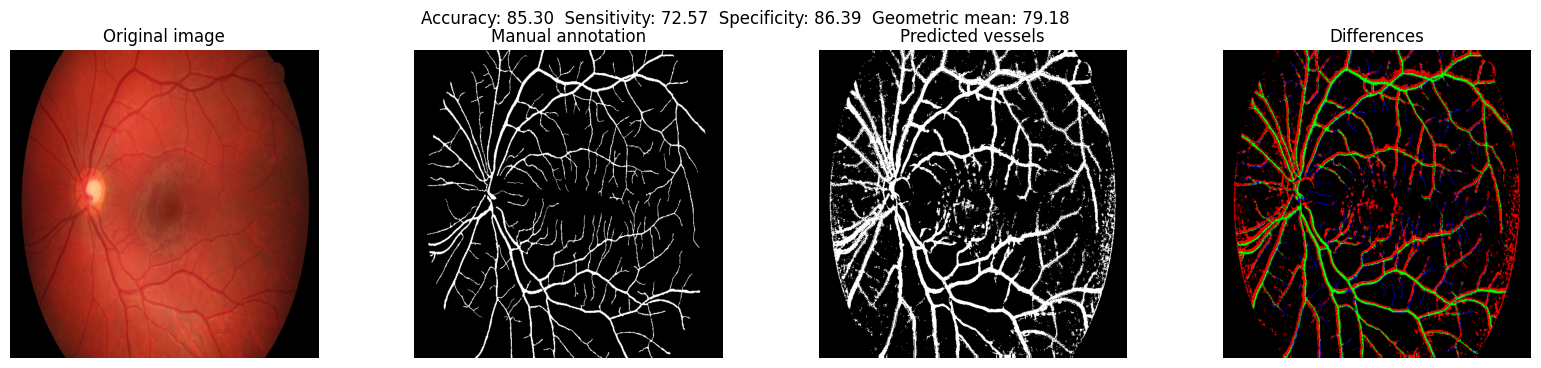

In [79]:
images_to_test = ['06', '08', '10', '12', '14']
for x in images_to_test:
    fig, axes = plt.subplots(figsize=(20,4),nrows=1, ncols=4)
    
    image, predicted_image, manual_image = process_images(x)
    
    acc,sens,spec,geo_mean, results_img = conf_matrix_for_image(predicted_image, manual_image)
    
    fig.suptitle(f"Accuracy: {acc:.2f}  Sensitivity: {sens:.2f}  Specificity: {spec:.2f}  Geometric mean: {geo_mean:.2f}")
    
    axes[0].set_title("Original image")
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    
    axes[1].set_title("Manual annotation")
    axes[1].imshow(manual_image, cmap='gray')
    axes[1].axis('off')
    
    axes[2].set_title("Predicted vessels")
    axes[2].imshow(predicted_image, cmap='gray')
    axes[2].axis('off')
    
    axes[3].set_title("Differences")
    axes[3].imshow(results_img, cmap='gray')
    axes[3].axis('off')

    plt.show()